# Simulation Settings

In [1]:
import os
import numpy as np
from cideMOD import (
    CellParser,
    SolverCrashed,
    init_results_folder,
    ModelOptions,
    CSI
)

In [2]:
overwrite = False
case = "Ai_2020"
data_path = f"../../data/data_{case}"
params = "params_LAM.json"

model_options = ModelOptions(mode='P2D', clean_on_exit=False, solve_LAM=True)

In [3]:
cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": 2,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": -1, 
                    "unit": "C", 
                    "t_max": {"value": 2, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 10,
                    "adaptive": True,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 3,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Pause",
                    "type": "Rest",
                    "t_max": {"value": 600, "unit": "s"},
                    "store_delay": -1,
                    "min_step": 10,
                    "adaptive": True
                },
                {
                    "name": "Charge-CC",
                    "type": "Current", 
                    "value": 1, 
                    "unit": "C", 
                    "t_max": {"value": 2, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 10,
                    "adaptive": True,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge-CV",
                    "type": "Voltage",
                    "value": 4.199,
                    "unit": "V",
                    "t_max": {"value": 600, "unit": "s"},
                    "store_delay": -1,
                    "min_step": 10,
                    "adaptive": True,
                    "events": [{
                        "type": "Current",
                        "value": 0.02,
                        "unit": "C",  
                        "atol": 1e-4, 
                        "rtol": 1e-3,
                        "goto": "Next" 
                    }]
                },
            ]}

cycling_test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
}

In [4]:
save_path = init_results_folder(
    f'{case}_LAM', overwrite=overwrite, copy_files=[os.path.join(data_path,params), model_options.dict(), cycling_test_plan], filenames = ['params', 'simulation_options', 'test_plan']
)

Saving results to /home/fenics/shared/cideMOD/examples/notebooks/results_Ai_2020_LAM


In [5]:
csi = CSI(os.path.join(data_path,params), model_options, save_path=save_path, overwrite=overwrite)
csi.read_test_plan(cycling_test_plan)

Capacidad Anodo: 0.07171427630498543
Capacidad Catodo: 0.07170672399797187
Capacidad Celda: 0.07170672399797187
Initial state:
{'SOC': 1, 'exterior_temperature': 298}
Steps:
0 -  Cycle 'Discharge Cycle' repeats 2 times:
	 0 - CC_Discharge: Apply -0.07170672399797187 A during 2 hours until [Voltage Trigger at 3 V]
	 1 - Pause: Rest during 10 minutes
	 2 - CC_Charge-CC: Apply 0.07170672399797187 A during 2 hours until [Voltage Trigger at 4.2 V]
	 3 - CV_Charge-CV: Apply 4.199 V during 10 minutes until [Current Trigger at 0.0014 A]


In [6]:
csi.run_test_plan()

Building mesh for P2D problem with 5 components and 150 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 496.0 dofs.

-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply -0.07170672399797187 A during 2 hours until [Voltage Trigger at 3 V]
Solving ...
initializing solution
Voltage is 3 V at 3510.00 s -02	Time: 58min 20s

Pause: Rest during 10 minutes7e-02	Time: 58min 30s
Solving ...
initializing solution
Reached max time 4116.71 0e+00	Time: 1h 8min 26s

CC_Charge-CC: Apply 0.07170672399797187 A during 2 hours until [Voltage Trigger at 4.2 V]
Solving ...
initializing solution
Voltage is 4.2 V at 6676.71 s 	Time: 1h 51min 6sK

CV_Charge-CV: Apply 4.199 V during 10 minutes until [Current Trigger at 0.0014 A]
Solving ...
initializing solution
Reached max time 7286.71 6e-02	Time: 2h 1min 16sK

-- Cycle 'Discharge Cycle', iteration n

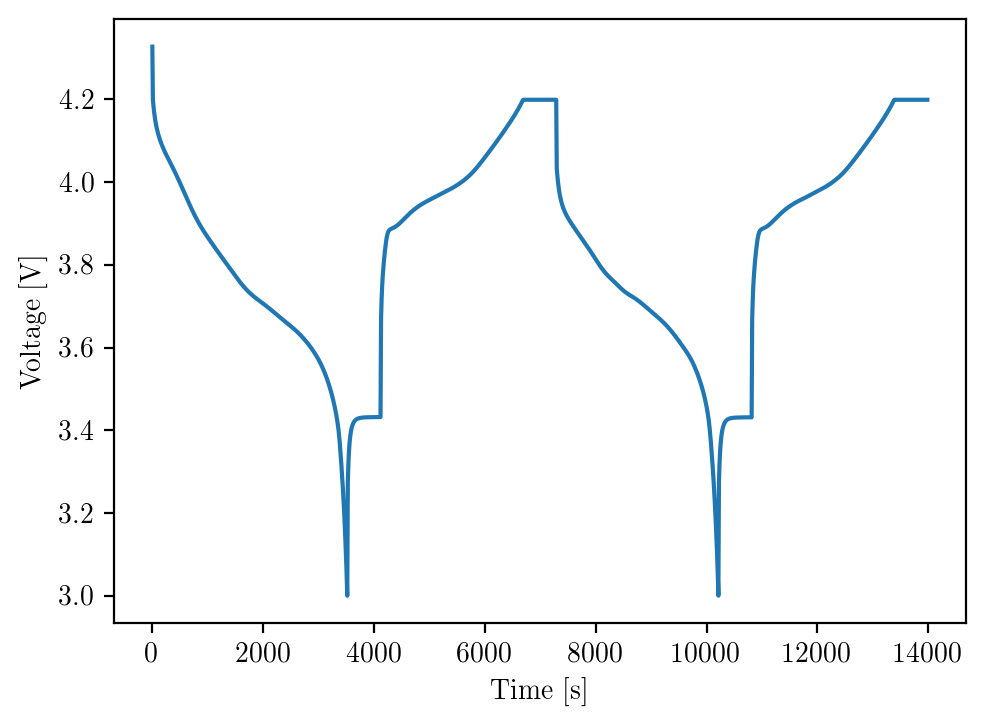

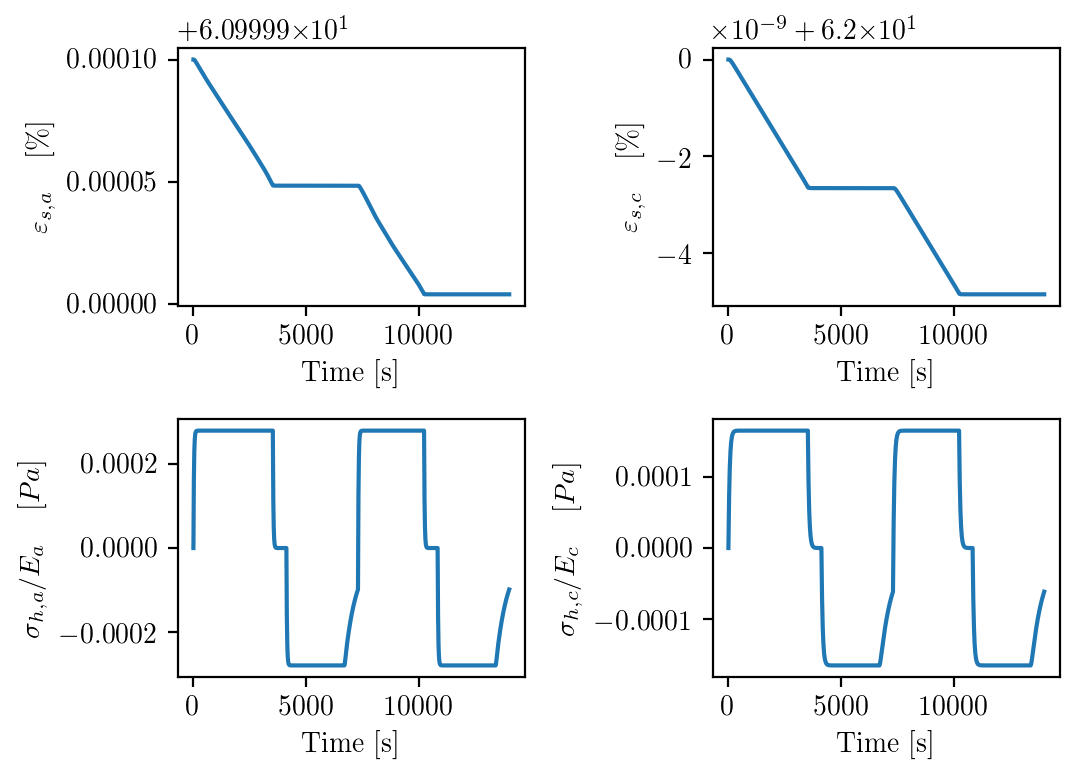

In [9]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Get global variables
time = np.array(csi.problem.WH.get_global_variable('time'), dtype = float)
voltage = np.array(csi.problem.WH.get_global_variable('voltage'), dtype = float)
eps_s_a0 = np.array(csi.problem.WH.get_global_variable('eps_s_a0_avg'), dtype = float)
eps_s_c0 = np.array(csi.problem.WH.get_global_variable('eps_s_c0_avg'), dtype = float)
sigma_h_a0 = np.array(csi.problem.WH.get_global_variable('sigma_h_a0_avg'), dtype = float)
sigma_h_c0 = np.array(csi.problem.WH.get_global_variable('sigma_h_c0_avg'), dtype = float)
E_a = csi.problem.cell.negative_electrode.active_materials[0].young
E_c = csi.problem.cell.positive_electrode.active_materials[0].young

# Plot voltage vs time
fig1, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
ax1.plot(time, voltage, "-", label='voltage')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")

# Plot eps_s_a0 vs time
fig2, axs = plt.subplots(2, 2, figsize=(5.5, 4), dpi=200)
axs[0,0].plot(time, eps_s_a0, "-", label='eps_s_a0')
axs[0,0].set_xlabel("Time [s]")
axs[0,0].set_ylabel(r"$\varepsilon_{s,a} \quad \left[\%\right]$")

# Plot eps_s_c0 vs time
axs[0,1].plot(time, eps_s_c0, "-", label='eps_s_c0')
axs[0,1].set_xlabel("Time [s]")
axs[0,1].set_ylabel(r"$\varepsilon_{s,c} \quad \left[\%\right]$")

# Plot sigma_h_a0 vs time
axs[1,0].plot(time, sigma_h_a0/E_a, "-", label='sigma_h_a0')
axs[1,0].set_xlabel("Time [s]")
axs[1,0].set_ylabel(r"$\sigma_{h,a}/E_a \quad \left[Pa\right]$")

# Plot sigma_h_c0 vs time
axs[1,1].plot(time, sigma_h_c0/E_c, "-", label='sigma_h_c0')
axs[1,1].set_xlabel("Time [s]")
axs[1,1].set_ylabel(r"$\sigma_{h,c}/E_c \quad \left[Pa\right]$")
plt.tight_layout()
plt.show()